### 6-8. 프로젝트 : 모든 장르 간 편향성 측정해 보기
지금까지 우리는 영화 시놉시스 코퍼스를 가지고 영화 구분과 영화 장르 간에 내재된 편향성을 측정하는 작업을 진행해 보았습니다.   
어느 정도는 우리의 상식과 일치하는 편향성이 측정되었을 것입니다.

이번에는 모든 장르에 대해 영화 구분과의 편향성 정도를 측정해 보겠습니다.   대부분의 과정은 이전 스텝에서 이미 진행한 내용을  
 참고해서 동일하게 진행 가능할 것입니다.

라이브러리 버전을 확인해 봅니다  
사용할 라이브러리 버전을 둘러봅시다.

In [ ]:
pip install konlpy

     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 448 kB 66.6 MB/s 


In [ ]:
# 필요한 패키지 불러오기 

import os
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from konlpy.tag import Okt
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from numpy import dot
from numpy.linalg import norm

### STEP 1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기

In [ ]:
with open('synopsis.txt', 'r') as file:
    for i in range(10):
        print(file.readline(), end='')

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.
 너무 쉽게 사랑에 빠진 두 사람... 상우는 주체할 수 없을 정도로 그녀에게 빨려든다.
 그러나 겨울에 만난 두 사람의 관계는 봄을 지나 여름을 맞이하면서 삐걱거린다.
 이혼 경험이 있는 은수는 상우에게 결혼할 생각이 없다며 부담스러운 표정을 내비친다.
 "어떻게 사랑이 변하니?..."라고 묻는 상우에게 은수는 그저 "헤어져" 라고 단호하게 말한다.
 영원히 변할 것 같지 않던 사랑이 변하고, 그 사실을 받아들이지 못하는 상우는 어찌 할 바를 모른다.


In [ ]:
# OKt를 사용해 토크나이징 하기

okt = Okt()
tokenized = []
with open('synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # 명사일 때만 tokenized 에 저장하게 만듦 
        tokenized.append(res)

In [ ]:
print(len(tokenized))

71156


### STEP 2. 추출된 결과로 embedding model 만들기

In [ ]:
# Word2Vec으로 embedding model 만들기 
from gensim.models import Word2Vec

model = Word2Vec(tokenized, size=100, window=5, min_count=3, sg=0)  
model.most_similar(positive=['영화'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  if __name__ == '__main__':


[('작품', 0.9035454988479614),
 ('다큐멘터리', 0.8606672883033752),
 ('드라마', 0.8304869532585144),
 ('영화로', 0.8285743594169617),
 ('소재', 0.8236442804336548),
 ('코미디', 0.8103840351104736),
 ('주제', 0.8051642179489136),
 ('감동', 0.802828311920166),
 ('형식', 0.8004211783409119),
 ('스토리', 0.7883025407791138)]

In [ ]:
# "사랑"과 가장 유사한 단어 찾아 보기
model.wv.most_similar(positive=['사랑'])

[('애정', 0.7321321368217468),
 ('행복', 0.7271773815155029),
 ('첫사랑', 0.7250370979309082),
 ('만남', 0.7089524269104004),
 ('이별', 0.704995334148407),
 ('진심', 0.7036697864532471),
 ('고백', 0.7006908655166626),
 ('아픔', 0.6999292373657227),
 ('연애', 0.69704270362854),
 ('우정', 0.6890978813171387)]

### STEP 3. target, attribute 단어 셋 만들기
이전 스텝에서는 TF-IDF를 사용해서 단어 셋을 만들었습니다. 이 방법으로도 어느 정도는 대표 단어를 잘 선정할 수 있습니다.  
 그러나 TF-IDF가 높은 단어를 골랐음에도 불구하고 중복되는 단어가 발생하는 문제가 있었습니다. 개념축을 표현하는 단어가  
  제대로 선정되지 않은 것은 WEAT 계산 결과에 악영향을 미칩니다.

TF-IDF를 적용했을 때의 문제점이 무엇인지 지적 가능하다면 그 문제점을 지적하고 스스로 방법을 개선하여 대표 단어 셋을  
 구축해 보기 바랍니다. TF-IDF 방식을 쓰더라도 중복된 단어를 잘 제거하면 여전히 유용한 방식이 될 수 있습니다.

In [ ]:
def read_token(file_name):
    okt = Okt()
    result = []
    with open(file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

#### 예술, 일반영화의 단어 선정

In [ ]:
art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

In [ ]:
art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])  # term-document matrix가 생성됨

print(X.shape)

(2, 41082)


In [ ]:
print(vectorizer.vocabulary_['영화'])
print(vectorizer.get_feature_names()[23976])

23976
영화


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 spart matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 spart matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
그녀, 자신, 시작, 위해, 사랑, 사람, 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

일반영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

In [ ]:
# 위에 출력한 것처럼 중복된 것이 많으므로 중복을 제외하고 상위n개의 단어를 추출
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# 시놉시스 리스트
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [ ]:
# 텍스트를 읽어 명사를 저장하기 

def read_token(file_name):
    okt = Okt()
    result = []
    with open(file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

In [ ]:
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(21, 42191)


In [ ]:
# 각 장르를 대표하는 단어들 추출
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

SF: 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 
가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 마을, 국제, 낙타, 
공연: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 
기타: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 
다큐멘터리: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 
드라마: 자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남편, 남자, 여자, 사람, 친구, 섹스, 위해, 마음, 결혼, 서로, 아내, 
뮤지컬: 뮤지컬, 사랑, 에스메랄다, 그녀, 음악, 충무로, 모차르트, 영화, 토스카, 자신, 니웨, 카바, 영화제, 바흐, 페뷔스, 
미스터리: 사건, 그녀, 시작, 자신, 위해, 사람, 발견, 사고, 진실, 죽음, 기억, 살인, 친구, 아내, 남자, 
범죄: 사건, 위해, 자신, 경찰, 시작, 그녀, 범죄, 조직, 살인, 사람, 마약, 형사, 남자, 모든, 살해, 
사극: 조선, 위해, 시작, 신기전, 사랑, 자신, 아가멤논, 황제, 그녀, 루안, 최고, 운명, 사람, 하선, 전쟁, 
서부극(웨스턴): 서부, 보안관, 위해, 벌린, 카우보이, 그레이프바인, 헨리, 마을, 자신, 개릿, 아이, 시작, 무법자, 프린트, 마적, 
성인물(에로): 그녀, 남편, 마사지, 자신, 섹스, 관계, 영화, 정사, 남자, 위해, 시작, 여자, 유부녀, 마음, 사랑, 
스릴러: 자신, 그녀, 사건, 시작, 

In [ ]:
# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성
from gensim.models import Word2Vec

model = Word2Vec(tokenized, size=100, window=5, min_count=3, sg=0)  
model.wv.most_similar(positive=['영화'])

[('작품', 0.9041412472724915),
 ('다큐멘터리', 0.8526518940925598),
 ('드라마', 0.8371528387069702),
 ('영화로', 0.8207826614379883),
 ('형식', 0.8142032027244568),
 ('코미디', 0.8060943484306335),
 ('감동', 0.8019383549690247),
 ('송일곤', 0.8009687066078186),
 ('주제', 0.8007487058639526),
 ('인터뷰', 0.7872595191001892)]

### STEP 4. WEAT score 계산과 시각화
영화 구분, 영화 장르에 따른 편향성을 측정하여 WEAT score로 계산해 보고 이를 Heatmap 형태로 시각화해 봅시다.  
 편향성이 두드러지는 영화장르 attribute 구성에는 어떤 케이스가 있는지 시각적으로 두드러지게 구성되면 좋습니다.

In [ ]:
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)  # 단어 w에 대해 A 데이터셋의 단어들과 코사인유사도를 구한다.
    c_b = cos_sim(w, B)  # 단어 w에 대해 B 데이터셋의 단어들과 코사인유사도를 구한다.
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B#, c_a, c_b

def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

In [ ]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [ ]:
A = np.array([model.wv[word] for word in target_art])
B = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        X = np.array([model.wv[word] for word in attributes[i]])
        Y = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

In [ ]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        if matrix[i][j] > 1.1 or matrix[i][j] < -1.1:
            print(genre_name[i], genre_name[j], matrix[i][j])

SF 멜로로맨스 -1.3401042
공포(호러) 다큐멘터리 1.149567
기타 멜로로맨스 -1.1896647
다큐멘터리 멜로로맨스 -1.4806242
다큐멘터리 미스터리 -1.2815553
다큐멘터리 성인물(에로) -1.2419643
다큐멘터리 스릴러 -1.1625898
멜로로맨스 뮤지컬 1.1296139
멜로로맨스 범죄 1.2338599
멜로로맨스 애니메이션 1.1653376
멜로로맨스 전쟁 1.4134326


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51313 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44277 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50672 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54252 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54840 missing from current font.
  font.set_

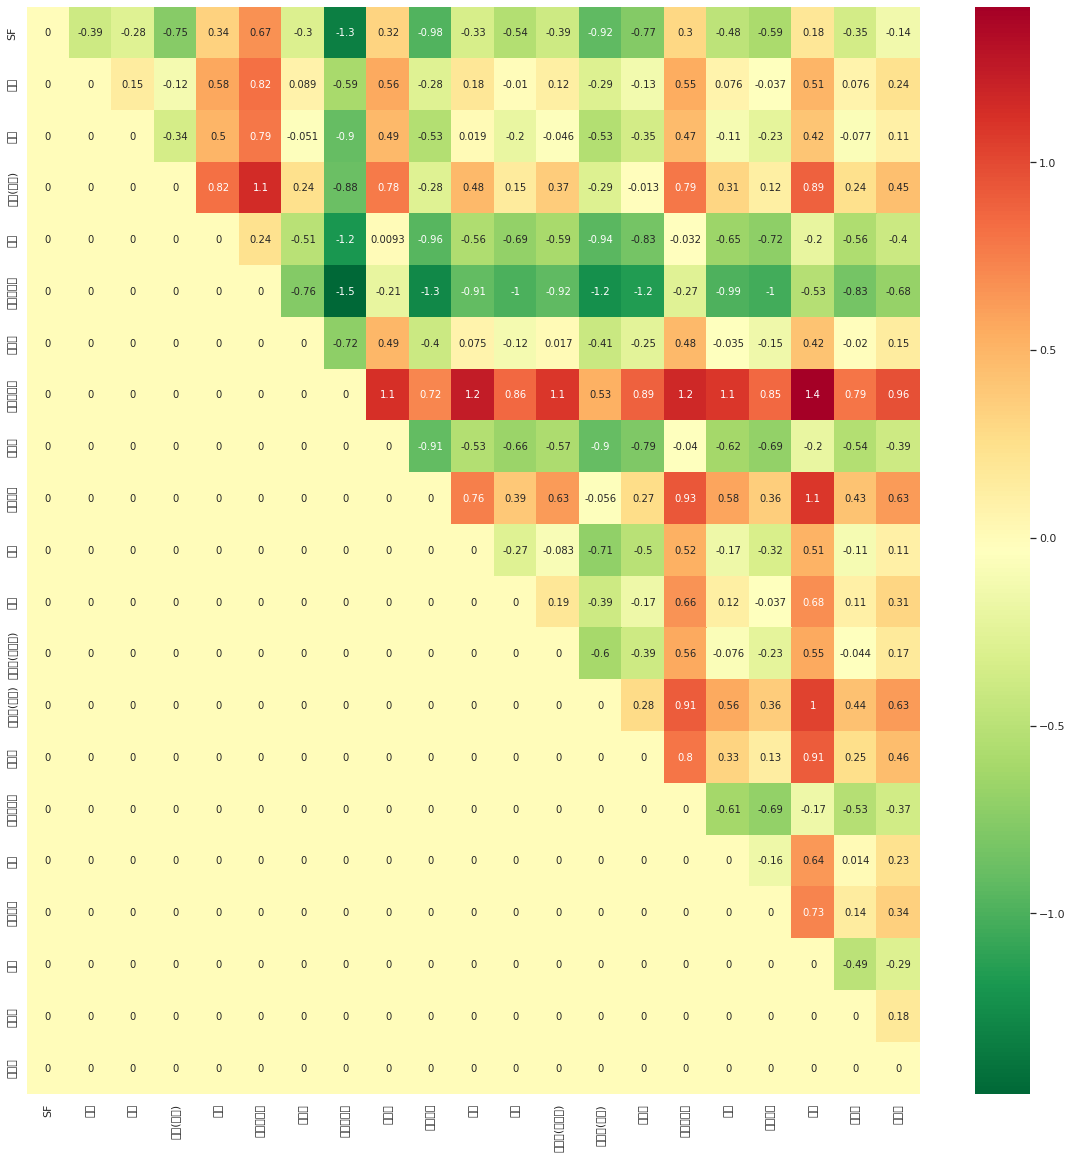

In [ ]:
# 시각화

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'Malgun Gothic'

np.random.seed(100)

# 한글 지원 폰트
sns.set(font="Noto Sans CJK JP")
plt.figure(figsize=(20,20))
ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r', annot_kws={"size": 10})
ax

### [회고] 

인공지능을 학습시킬 때 학습데이터의 편향성으로 모델이 뱉은 결과도 편향성을 띌 수 있다는 것은 알고 있었는데 이렇게 평향성 정도를 측정할 수 있는 지표가 있다는 것이 신기했다. 

문제는 WEAT 지표가 좋지 않다고 할 경우 학습데이터를 어떻게 처리해야 하는지에 
대한 언급이 없어서 이 지표를 어디에 써야 할지 모르겠다. 